In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Load hourly data
try:
    df_hourly = pd.read_csv('/Users/gokul/Air/city_hour.csv')  # Replace with your hourly data file path
    print("Hourly data loaded successfully!")
except FileNotFoundError:
    print("Error: Hourly data file not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred during hourly data loading: {e}")

# Load daily data
try:
    df_daily = pd.read_csv('/Users/gokul/Air/city_day.csv')  # Replace with your daily data file path
    print("Daily data loaded successfully!")
except FileNotFoundError:
    print("Error: Daily data file not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred during daily data loading: {e}")


# Check if both dataframes are loaded successfully
if 'df_hourly' in locals() and 'df_daily' in locals():
    print("Both hourly and daily data loaded. Proceeding...")
else:
    print("Error: One or both datasets failed to load. Please check file paths and try again.")

Hourly data loaded successfully!
Daily data loaded successfully!
Both hourly and daily data loaded. Proceeding...


In [13]:
# Cell 2: Cleaning and Preprocessing Daily Data (df_daily)

# 1. Convert 'Date' to datetime objects and set as index
try:
    df_daily['Date'] = pd.to_datetime(df_daily['Date'], errors='coerce')
    df_daily = df_daily.set_index('Date')
    print("Daily Date set as index.")
except KeyError:
    print("Error: 'Date' column not found in daily data.")
except Exception as e:
    print(f"An error occurred during daily Date conversion: {e}")


# 2. Drop specified columns (Xylene, Toluene, Benzene)
columns_to_drop_daily = ['Xylene', 'Toluene', 'Benzene']
df_daily.drop(columns=columns_to_drop_daily, inplace=True)
print(f"Shape of daily DataFrame after dropping specified columns: {df_daily.shape}")

# 3. Drop rows where ALL pollutant measurements are NaN
pollutants_daily = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'AQI']
df_daily.dropna(subset=pollutants_daily, how='all', inplace=True)
print(f"Shape of daily DataFrame after dropping rows with all NaN pollutants: {df_daily.shape}")


# 4. Impute missing values (ffill then bfill) - Daily Data
for col in ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'AQI']:
    df_daily[col] = df_daily[col].ffill().bfill()

# 5. Create AQI_Bucket from imputed AQI
bins = [0, 50, 100, 200, 300, 400, float('inf')]
labels = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
df_daily['AQI_Bucket'] = pd.cut(df_daily['AQI'], bins=bins, labels=labels, right=False)


# 6. Print missing value information after cleaning and imputation
print("Missing values in daily DataFrame after cleaning and imputation:")
print(df_daily.isnull().sum())
print(df_daily.info())
df_daily.index

Daily Date set as index.
Shape of daily DataFrame after dropping specified columns: (29531, 12)
Shape of daily DataFrame after dropping rows with all NaN pollutants: (28013, 12)
Missing values in daily DataFrame after cleaning and imputation:
City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
AQI           0
AQI_Bucket    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28013 entries, 2015-01-01 to 2020-07-01
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   City        28013 non-null  object  
 1   PM2.5       28013 non-null  float64 
 2   PM10        28013 non-null  float64 
 3   NO          28013 non-null  float64 
 4   NO2         28013 non-null  float64 
 5   NOx         28013 non-null  float64 
 6   NH3         28013 non-null  float64 
 7   CO          28013 non-null  float64 
 8   S

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29',
               '2020-06-30', '2020-07-01'],
              dtype='datetime64[ns]', name='Date', length=28013, freq=None)

Mean Absolute Error (MAE): 21.292091617585818
Mean Squared Error (MSE): 2074.277534999414
Root Mean Squared Error (RMSE): 45.54423712171952
R^2 Score: 0.8813353714754613
Feature Importance:
PM2.5    0.494411
CO       0.361342
NO       0.034726
PM10     0.034257
O3       0.017724
NOx      0.017012
SO2      0.016923
NO2      0.015603
NH3      0.008002
dtype: float64


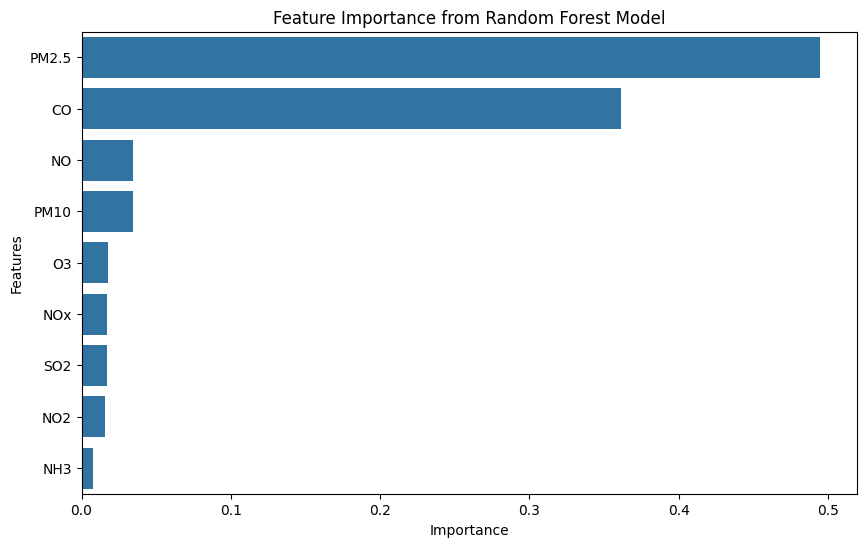

In [14]:
# Cell 3: Applying Random Forest Algorithm to Daily Data (df_daily)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Features and target
X = df_daily[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']]  # Predictor variables
y = df_daily['AQI']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance from Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Mean Absolute Error (MAE): 28.855702302338035
Mean Squared Error (MSE): 3602.7200160628236
Root Mean Squared Error (RMSE): 60.02266252060819
R^2 Score: 0.7938967061203139
Feature Importance:
PM2.5    0.493424
CO       0.359093
NO       0.036436
PM10     0.034046
O3       0.018849
NOx      0.018014
SO2      0.017047
NO2      0.015164
NH3      0.007928
dtype: float64


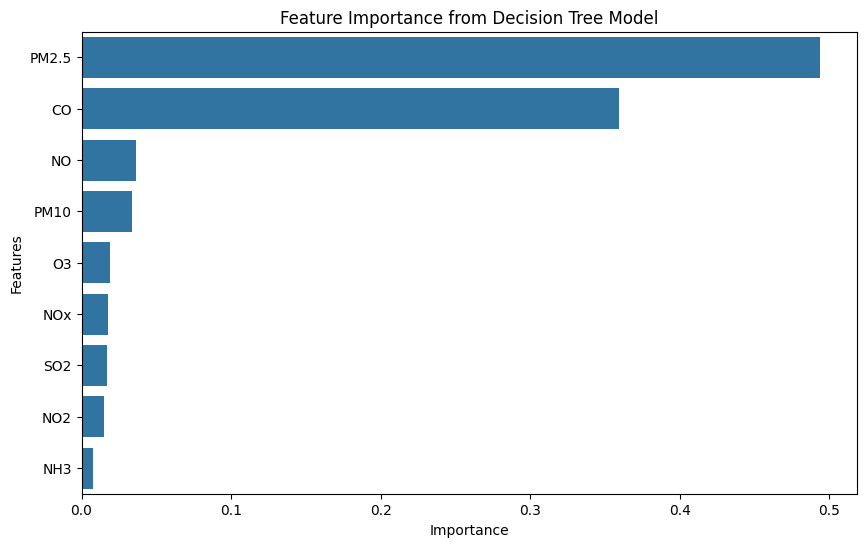

Additional Results for Decision Tree Regression:
Decision Tree Regression Metrics: 28.856 0.794 60.023 3602.720 0.493 0.359 0.036 0.034


/var/folders/x9/41s1rzhs0md0rcb1fxhktxwh0000gn/T/ipykernel_14291/2228946579.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Decision Tree Regression Metrics: {mae_dt:.3f} {r2_dt:.3f} {rmse_dt:.3f} {mse_dt:.3f} {feature_importance_dt[0]:.3f} {feature_importance_dt[1]:.3f} {feature_importance_dt[2]:.3f} {feature_importance_dt[3]:.3f}")


In [15]:
# Cell 4: Applying Decision Tree Regression to Daily Data (df_daily)

from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_dt}")
print(f"Mean Squared Error (MSE): {mse_dt}")
print(f"Root Mean Squared Error (RMSE): {rmse_dt}")
print(f"R^2 Score: {r2_dt}")

# Feature Importance
feature_importance_dt = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance_dt)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_dt, y=feature_importance_dt.index)
plt.title("Feature Importance from Decision Tree Model")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Additional Results (as requested)
print("Additional Results for Decision Tree Regression:")
print(f"Decision Tree Regression Metrics: {mae_dt:.3f} {r2_dt:.3f} {rmse_dt:.3f} {mse_dt:.3f} {feature_importance_dt[0]:.3f} {feature_importance_dt[1]:.3f} {feature_importance_dt[2]:.3f} {feature_importance_dt[3]:.3f}")

Mean Absolute Error (MAE): 23.459860788863104
Mean Squared Error (MSE): 2548.427785115117
Root Mean Squared Error (RMSE): 50.48195504450196
R^2 Score: 0.8542103304211971


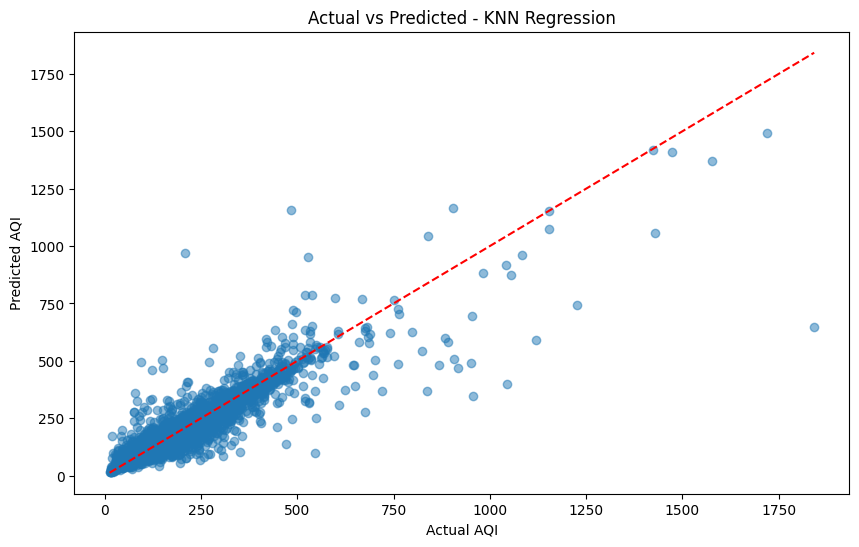

Additional Results for KNN Regression:
KNN Regression Metrics: 23.460 0.854 50.482 2548.428


In [16]:
# Cell 5: Applying k-Nearest Neighbors Regression to Daily Data (df_daily)

from sklearn.neighbors import KNeighborsRegressor

# Initialize KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_knn}")
print(f"Mean Squared Error (MSE): {mse_knn}")
print(f"Root Mean Squared Error (RMSE): {rmse_knn}")
print(f"R^2 Score: {r2_knn}")

# Feature Importance
# KNN does not provide direct feature importance, but we can evaluate performance
# on different subsets of features or visualize errors in predictions

# Visualizing the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted - KNN Regression")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

# Additional Results (if needed)
print("Additional Results for KNN Regression:")
print(f"KNN Regression Metrics: {mae_knn:.3f} {r2_knn:.3f} {rmse_knn:.3f} {mse_knn:.3f}")

Mean Absolute Error (MAE): 34.11520782762998
Mean Squared Error (MSE): 6531.91507949175
Root Mean Squared Error (RMSE): 80.82026403997793
R^2 Score: 0.6263242196941885


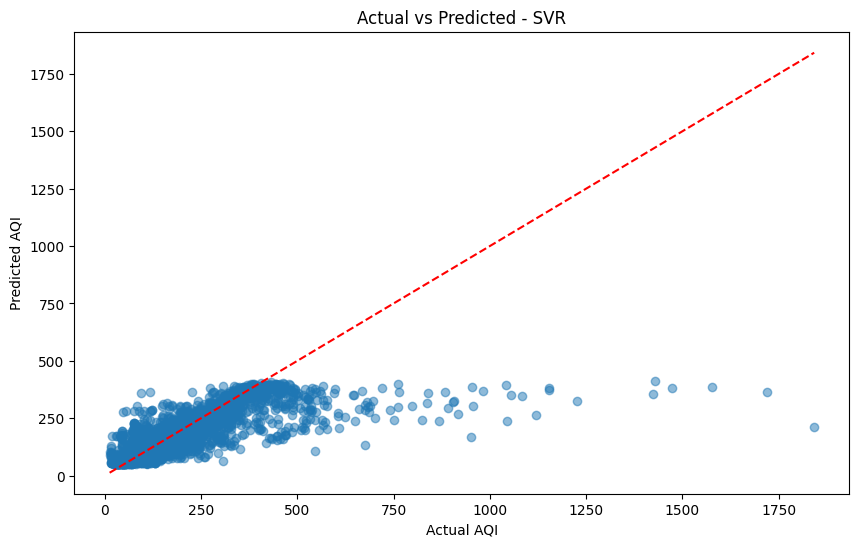

Additional Results for SVR:
SVR Regression Metrics: 34.115 0.626 80.820 6531.915


In [17]:
# Cell 6: Applying Support Vector Regression to Daily Data (df_daily)

from sklearn.svm import SVR

# Initialize SVR model
svr_model = SVR(kernel='rbf')  # You can experiment with 'linear' or 'poly' kernels as well

# Train the model
svr_model.fit(X_train, y_train)

# Predict on test set
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_svr}")
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"R^2 Score: {r2_svr}")

# Visualizing the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted - SVR")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

# Additional Results (if needed)
print("Additional Results for SVR:")
print(f"SVR Regression Metrics: {mae_svr:.3f} {r2_svr:.3f} {rmse_svr:.3f} {mse_svr:.3f}")

Mean Absolute Error (MAE): 34.05134895274553
Mean Squared Error (MSE): 4076.731290783558
Root Mean Squared Error (RMSE): 63.84928574998751
R^2 Score: 0.7667796155275187


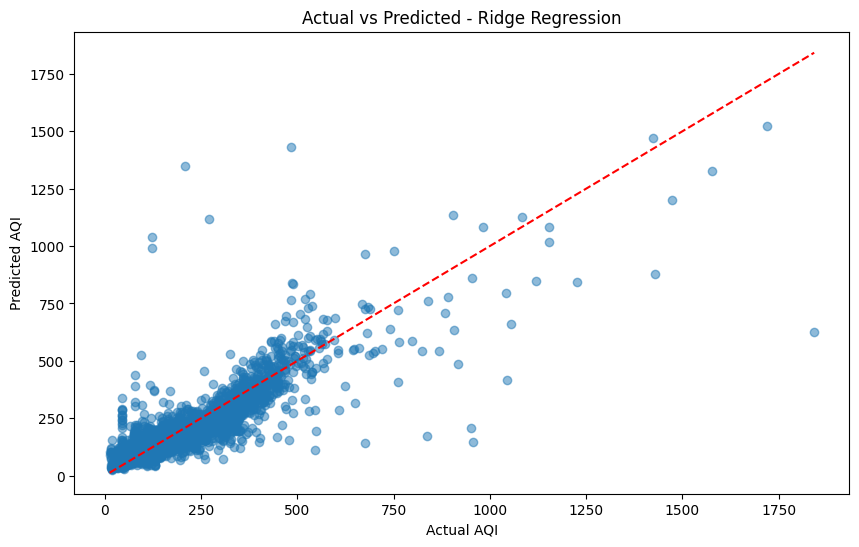

Additional Results for Ridge Regression:
Ridge Regression Metrics: 34.051 0.767 63.849 4076.731


In [18]:
# Cell 7: Applying Ridge Regression to Daily Data (df_daily)

from sklearn.linear_model import Ridge

# Initialize Ridge model
ridge_model = Ridge(alpha=1.0)  # You can experiment with different alpha values

# Train the model
ridge_model.fit(X_train, y_train)

# Predict on test set
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_ridge}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"R^2 Score: {r2_ridge}")

# Visualizing the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted - Ridge Regression")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

# Additional Results (if needed)
print("Additional Results for Ridge Regression:")
print(f"Ridge Regression Metrics: {mae_ridge:.3f} {r2_ridge:.3f} {rmse_ridge:.3f} {mse_ridge:.3f}")

Mean Absolute Error (MAE): 34.05195115604954
Mean Squared Error (MSE): 4076.677993256082
Root Mean Squared Error (RMSE): 63.84886837882158
R^2 Score: 0.7667826645560082


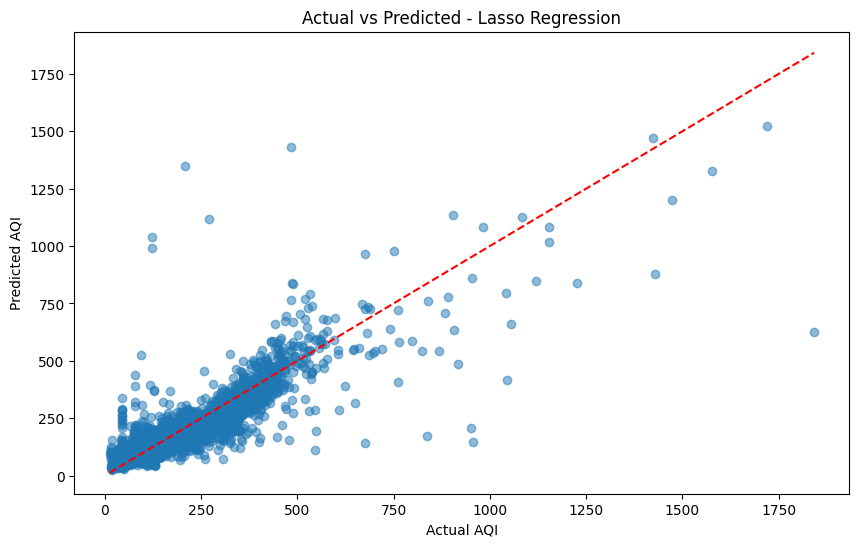

Additional Results for Lasso Regression:
Lasso Regression Metrics: 34.052 0.767 63.849 4076.678


In [19]:
# Cell 8: Applying Lasso Regression to Daily Data (df_daily)

from sklearn.linear_model import Lasso

# Initialize Lasso model
lasso_model = Lasso(alpha=0.1)  # You can experiment with different alpha values

# Train the model
lasso_model.fit(X_train, y_train)

# Predict on test set
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the model
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_lasso}")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"R^2 Score: {r2_lasso}")

# Visualizing the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted - Lasso Regression")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

# Additional Results (if needed)
print("Additional Results for Lasso Regression:")
print(f"Lasso Regression Metrics: {mae_lasso:.3f} {r2_lasso:.3f} {rmse_lasso:.3f} {mse_lasso:.3f}")

Mean Absolute Error (MAE): 22.262547074780386
Mean Squared Error (MSE): 2166.401048590327
Root Mean Squared Error (RMSE): 46.54461352928314
R^2 Score: 0.8760651979648351


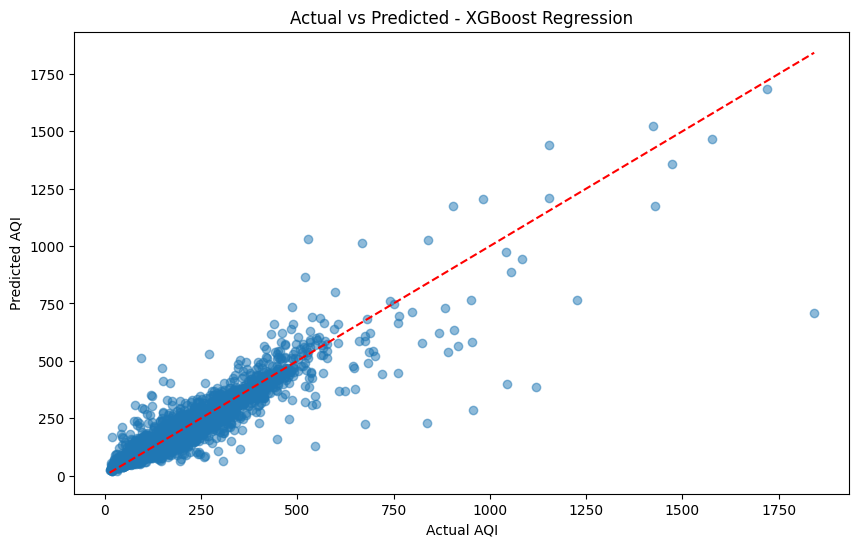

Additional Results for XGBoost Regression:
XGBoost Regression Metrics: 22.263 0.876 46.545 2166.401


In [25]:
# Cell 9: Applying XGBoost Regression to Daily Data (df_daily)

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R^2 Score: {r2_xgb}")

# Visualizing the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted - XGBoost Regression")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

# Additional Results (if needed)
print("Additional Results for XGBoost Regression:")
print(f"XGBoost Regression Metrics: {mae_xgb:.3f} {r2_xgb:.3f} {rmse_xgb:.3f} {mse_xgb:.3f}")